<a href="https://colab.research.google.com/github/ManuelOtt-code/Project-DC/blob/master/LogReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin





In [2]:
def drop_non_numeric_columns(df):
    """Drops columns from a DataFrame that do not contain numeric values.

    Args:
        df: The input DataFrame.

    Returns:
        A new DataFrame with non-numeric columns removed.
    """
    numeric_df = df.select_dtypes(include=np.number)
    return numeric_df

In [56]:
# Load data
train_df = pd.read_csv("Landrum_All_training_mordred.csv")
test_df = pd.read_csv("Landrum_All_training_mordred.csv")

train_df=drop_non_numeric_columns(train_df)
test_df=drop_non_numeric_columns(test_df)

# Separate features and labels
X_train = train_df.drop(columns=["active", "Unnamed: 0"], errors="ignore")
y_train = train_df["active"]
X_test = test_df.drop(columns=["active", "Unnamed: 0"], errors="ignore")
y_test = test_df["active"]



# Align and drop missing
shared_cols = X_train.columns.intersection(X_test.columns)
X_train = X_train[shared_cols].dropna(axis=1)
X_test = X_test[X_train.columns].dropna(axis=1)





<ipython-input-56-5a2c0147f8d0>:2: DtypeWarning: Columns (7,8,9,10,11,12,13,14,15,16,17,18,56,57,58,59,60,61,62,63,64,143,144,152,153,155,156,157,158,159,160,161,170,171,179,180,188,189,197,198,206,207,215,216,224,225,233,234,236,237,238,239,240,241,242,243,244,263,264,265,266,267,268,269,270,271,344,345,346,347,348,349,350,359,360,368,369,371,372,373,374,375,376,377,386,387,395,396,404,405,413,414,422,423,431,432,440,441,449,450,452,453,454,455,456,457,465,466,473,474,476,477,478,479,480,481,489,490,497,498,505,506,513,514,521,522,529,530,537,538,545,546,548,549,550,551,552,553,561,562,569,570,572,573,574,575,576,577,585,586,593,594,601,602,609,610,617,618,625,626,633,634,641,642,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,72

In [45]:
# Define pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ("var_thresh", VarianceThreshold(threshold=0.01)),
    ('select', SelectKBest(score_func=f_classif)),
    ('logreg', LogisticRegression(max_iter=1000))
])

param_grid = [
    {
        'logreg__penalty': ['l1'],
        'logreg__C': [0.06, 0.070, 0.075],
        'logreg__solver': ['saga'],
        'select__k': [10, 20, 50]
    },
    {
        'logreg__penalty': ['l2'],
        'logreg__C': [0.06, 0.070, 0.075],
        'logreg__solver': ['saga'],
        'select__k': [10, 20, 50]
    },
    {
        'logreg__penalty': ['elasticnet'],
        'logreg__C': [0.06, 0.070, 0.075],
        'logreg__solver': ['saga'],
        'logreg__l1_ratio': [0.10, 0.20, 0.30],
        'select__k': [10, 20, 50]
    }

]

Best parameters: {'logreg__C': 0.075, 'logreg__penalty': 'l2', 'logreg__solver': 'saga', 'select__k': 50}
Best cross-validation accuracy: 0.7492138412124862


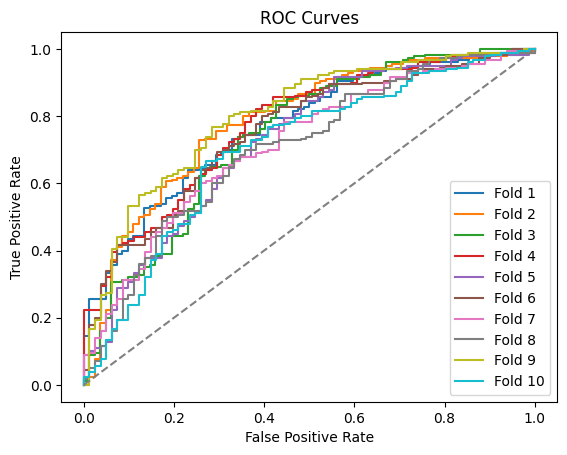

Average accuracy: 0.7440 	 and std err: 0.0078
Average precision: 0.7655 	 and std err: 0.0063
Average F1 score: 0.8299 	 and std err: 0.0049
Average AUC score: 0.7476 	 and std err: 0.0109


{'accuracies': [0.7519083969465649,
  0.7709923664122137,
  0.7595419847328244,
  0.7547892720306514,
  0.7471264367816092,
  0.735632183908046,
  0.7126436781609196,
  0.7279693486590039,
  0.7777777777777778,
  0.7011494252873564],
 'precisions': [0.7699530516431925,
  0.7884615384615384,
  0.7772511848341233,
  0.7871287128712872,
  0.7567567567567568,
  0.7630331753554502,
  0.7488151658767772,
  0.7400881057268722,
  0.7877358490566038,
  0.7361111111111112],
 'f1_scores': [0.8346055979643766,
  0.845360824742268,
  0.8388746803069054,
  0.8324607329842932,
  0.835820895522388,
  0.8235294117647058,
  0.8081841432225064,
  0.8255528255528255,
  0.8520408163265306,
  0.803030303030303],
 'auc_scores': [np.float64(0.7692411924119241),
  np.float64(0.7834010840108401),
  np.float64(0.7435636856368563),
  np.float64(0.7731138545953362),
  np.float64(0.7255144032921811),
  np.float64(0.7546639231824417),
  np.float64(0.7160493827160493),
  np.float64(0.7040466392318244),
  np.float64(0

In [57]:
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Run grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Output best model and parameters
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Use the best model to predict
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
evaluate_model_with_cv(best_model, X_train, y_train, random_state=21)




In [53]:
def evaluate_model_with_cv(model, X, y, random_state):
    """
    Evaluate a model using 10-fold cross-validation and return performance metrics.

    Parameters:
        model: The model to evaluate
        X: Feature matrix (DataFrame or array)
        y: Target vector
        random_state: Random seed for reproducibility

    Returns:
        Dictionary with performance metrics and arrays of per-fold metrics
    """
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import (
        accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve
    )
    import matplotlib.pyplot as plt

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

    metrics = {
        'accuracies': [],
        'precisions': [],
        'f1_scores': [],
        'auc_scores': []
    }

    plt.figure()

    for k, (train_index, test_index) in enumerate(skf.split(X, y)):
        # Proper slicing for DataFrame or array
        if isinstance(X, pd.DataFrame):
            X_train_fold = X.iloc[train_index]
            X_test_fold = X.iloc[test_index]
        else:
            X_train_fold = X[train_index]
            X_test_fold = X[test_index]

        y_train_fold = y[train_index]
        y_test_fold = y[test_index]

        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_test_fold)
        y_proba = model.predict_proba(X_test_fold)[:, 1]

        # Metrics
        metrics['accuracies'].append(accuracy_score(y_test_fold, y_pred))
        metrics['precisions'].append(precision_score(y_test_fold, y_pred))
        metrics['f1_scores'].append(f1_score(y_test_fold, y_pred))
        metrics['auc_scores'].append(roc_auc_score(y_test_fold, y_proba))

        fpr, tpr, _ = roc_curve(y_test_fold, y_proba)
        plt.plot(fpr, tpr, label=f"Fold {k+1}")

    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend()
    plt.show()

    metric_display_names = {
        'accuracies': 'accuracy',
        'precisions': 'precision',
        'f1_scores': 'F1 score',
        'auc_scores': 'AUC score'
    }
    for metric_name, values in metrics.items():
        display_name = metric_display_names[metric_name]
        print(f"Average {display_name}: {np.mean(values):.4f} \t and std err: {stats.sem(values):.4f}")

    return metrics



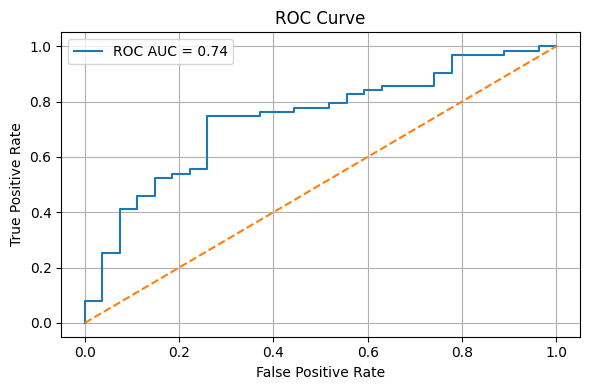

In [33]:
# Evaluate
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(y_test, y_proba):.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

